
 vid0118_0132  | score :  1  | diagnosis :  2
locp =  {'max': [21, 72, 129, 191, 253], 'min': [40, 95, 151, 212]}
5
first =  21


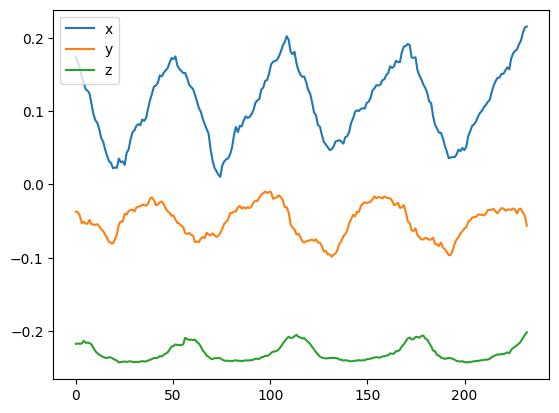

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from plotly.subplots import make_subplots
import os
from RASCoPy import recurrence, opti_epsi, symbolic_series
import sys
sys.path.insert(0, os.getcwd())
import joblib
import pandas as pd


def pattern_in_serie(w, s):
    w_str = ''
    s_str = ''
    for a in w:
        w_str=w_str+str(a)
    for b in s:
        s_str = s_str+str(b)
    return s_str in w_str

while(True):
    #name = input("\nEnter the name of the json: ")
    name = "data_20-03"
    if os.path.exists(name+".json"):
        break
    else:
        print("json doesn't exist")
data = joblib.load(name+".json")

if all(isinstance(valeur, dict) for valeur in data.values()):
    for vname, video in data.items():
        if 'diag' in video:
            print(vname, ":", video['sex'], " --> ", video['diag'], " | length: ", video['joints3D'].shape[0])
    '''while(True):
        #videoname = input("\nEnter the name of the video: ")
        videoname = "OAW01"
        if videoname in data:
            break
        else:
            print("Video doesn't exist")'''
    for videoname in data:
        passer = 0
        vidname = data[videoname]
        donnees = pd.read_excel('label_info_120.xlsx')
        ligne = donnees.loc[donnees['vidname'] == videoname]
        diagno = ligne['diag'].values[0]
        scor = ligne['score'].values[0]
        if diagno == 0:
          passer = 1
        if passer == 0:
            print("\n", videoname," | score : ",scor," | diagnosis : ",diagno)
            data_final=np.array(vidname['joints3D'])
            x = np.zeros((data_final.shape[1], data_final.shape[0], data_final.shape[2]))
            for k in range(data_final.shape[1]):
                x[k,:,0]=data_final[:,k,2]
                x[k,:,1]=data_final[:,k,0]
                x[k,:,2]=data_final[:,k,1]
            x[:, :, 2] *= -1
            x[:, :, 1] *= -1

            joints = [12,13,14]
            y = np.mean(x[joints,:,:],axis=0)

            step=0.001
            maxp,minp,locp = opti_epsi.nbr_peaks(y)
            if 0 in locp['min']: 
                locp['min'].pop(0)
            if 0 in locp['max']:
                locp['max'].pop(0)
            print("locp = ",locp)
            print(len(locp['max']))
            if len(locp['max'])>=5 and len(locp['min'])>=5:
                first=min(min(locp['max']),min(locp['min']))
                print("first = ",first)
                if first in locp['max']:
                    y=y[locp['max'][0]:locp['max'][4],:]
                if first in locp['min']:
                    y=y[locp['min'][0]:locp['min'][4],:]
                T=y.shape[0]
                l = np.linspace(0,T,T)
                figu = plt.figure()
                plt.plot(l,y[:,0],label='x')
                plt.plot(l,y[:,1],label='y')
                plt.plot(l,y[:,2],label='z')
                plt.legend()
                plt.show(block=False)
                epsi = opti_epsi.epsi_entropy(y, step)
                R = recurrence.rec_mat(y,epsi)
                serie = symbolic_series.symbolic_serie(R)
                symbolic_series.colored_sym_serie(serie,y)

                stock=[]
                #serie = [1,1,0,1,0,0,0,2,2,2,0,0,0,1,1,1,0,0,0,2,2,2,0,0,0,1,1,1,0,0,0,2,2,2]
                countarg={}
                k=np.zeros(len(np.unique(serie)))
                k=k.astype(int)
                serie = serie.astype(int)
                stockarg = {}

                for i in range (1,len(serie)):
                    if serie[i-1] in stockarg:
                        if 0 <= k[serie[i-1]] < len(stockarg[serie[i-1]]):
                            stockarg[serie[i-1]][k[serie[i-1]]]=stockarg[serie[i-1]][k[serie[i-1]]]+i-1
                            countarg[serie[i-1]][k[serie[i-1]]]=countarg[serie[i-1]][k[serie[i-1]]]+1
                        else:
                            stockarg[serie[i-1]].append(i-1)
                            countarg[serie[i-1]].append(1)    
                    else:
                        stockarg[serie[i-1]]=[]
                        stockarg[serie[i-1]].append(i-1)
                        countarg[serie[i-1]]=[]
                        countarg[serie[i-1]].append(1)

                    if serie[i]!=serie[i-1]:
                        stock.append(serie[i-1])
                        if i == len(serie)-1:
                            stock.append(serie[i])
                            if serie[i] in stockarg:
                                stockarg[serie[i]].append(i)
                                countarg[serie[i]].append(1)
                            else:
                                stockarg[serie[i]]=[]
                                stockarg[serie[i]].append(i)
                                countarg[serie[i]]=[]
                                countarg[serie[i]].append(1)
                        if serie[i-1] in stock:
                            k[serie[i-1]]=k[serie[i-1]]+1

                    if i == len(serie)-1 and serie[i]==serie[i-1]:
                        stock.append(serie[i])
                        stockarg[serie[i]][k[serie[i]]]=stockarg[serie[i]][k[serie[i]]]+i
                        countarg[serie[i]][k[serie[i]]]=countarg[serie[i]][k[serie[i]]]+1

                k=np.zeros(len(np.unique(stock)))
                k=k.astype(int)
                for i in range(len(stock)-2):
                    k[stock[i]] = k[stock[i]]+1
                    if stock[i]!=0 and stock[i]==stock[i+2] and stock[i+1] == 0:
                        stockarg[stock[i]][k[stock[i]]-1] = stockarg[stock[i]][k[stock[i]]-1] + stockarg[stock[i]][k[stock[i]]]
                        stockarg[stock[i]].pop(k[stock[i]])
                        countarg[stock[i]][k[stock[i]]-1] = countarg[stock[i]][k[stock[i]]-1] + countarg[stock[i]][k[stock[i]]]
                        countarg[stock[i]].pop(k[stock[i]])
                        k[stock[i]]=k[stock[i]]-1

                print(stockarg)
                print(countarg)

                for key in stockarg:
                    for val in range(len(stockarg[key])):
                        stockarg[key][val] = stockarg[key][val]/countarg[key][val]
                print(stockarg)

                distance={}
                for key in stockarg:
                    if key!=0:
                        for val in range(len(stockarg[key])-1):
                            dist=stockarg[key][val+1]-stockarg[key][val]
                            if key in distance:
                                distance[key].append(dist)
                            else:
                                distance[key]=[]
                                distance[key].append(dist)
                print(distance)

                f=[]
                for key in stockarg:
                    if key!=0:
                        f.append(len(stockarg[key]))
                print(f)

                erreur_rec = []
                for i in f:
                    if i<4:
                        err = abs(i-4)/4
                    elif i>5:
                        err = abs(i-5)/5
                    else:
                        err = 0
                    erreur_rec.append(err)
                print(erreur_rec)

                sum_err = 0
                for i in erreur_rec:
                    sum_err = sum_err+i
                #err_moy = sum_err/len(erreur_rec)
                print("sum_err = ",sum_err)


                etype={}
                h=0
                for key in distance:
                    if f[h] >= 3:
                        ecart_type = np.std(distance[key])
                        etype[key] = ecart_type
                    h=h+1
                print("\nEcart Type = ",etype)

                sum_etype=0
                for key in etype:
                    sum_etype = sum_etype+etype[key]
                moy_etype = sum_etype/len(etype)
                print("sum_etype = ",moy_etype)

                serie = np.array(serie)
                serie = serie.astype(int)
                print(serie)
                order = []
                for i in range(len(serie)-1):
                    if i == 0:
                        order.append(serie[i])
                    if serie[i]!=serie[i+1]:
                        order.append(serie[i+1])
                print(order)
                order2=order
                ind=[]
                ind2 = []
                for i in range(len(order)-2):
                    if order[i]!=0 and order[i+1]==0 and order[i+2]==order[i]:
                        ind.append(i+2)
                for i in ind:
                    order.pop(i)
                    for j in range(len(ind)):
                        ind[j]=ind[j]-1
                for i in range(len(order)-1):
                    if order[i] == order[i+1]:
                        ind2.append(i)
                for i in ind2:
                    order.pop(i)
                    for j in range(len(ind2)):
                        ind2[j]=ind2[j]-1
                print(order)

                C_LZ = 0
                i = 0
                W_LZ = []
                W_LZ.append(order[i])
                i = 1
                while i < len(order):
                    j = i
                    Bool = pattern_in_serie(W_LZ[:j], str(order[j]))
                    if Bool == False:
                        W_LZ.append(str(order[i]))
                        i = i + 1
                    else:
                        while Bool == True:
                            j = j + 1
                            if j >= len(order):
                                break
                            Bool = pattern_in_serie(W_LZ[:j], order[i:j + 1])
                        W_LZ.append(''.join(map(str, order[i:j + 1])))
                        i = j + 1
                C_LZ = len(W_LZ)
                C_LZ_n = C_LZ/len(order)
                print("\n\n Regularity of the sequence = ",C_LZ)


                join = "12,13,14"
                donnees = pd.read_excel('rec_analysis.xlsx')
                if join+" : sum_err" in donnees.columns:
                    if videoname in donnees['vidname'].values:
                        donnees.loc[videoname, join+" : sum_err"] = round(sum_err,2)
                        donnees.to_excel('rec_analysis.xlsx', index=False)
                    else:
                        donnees.loc[videoname] = np.nan
                        donnees.loc[videoname, join + " : sum_err"] = round(sum_err, 2)
                        donnees.to_excel('rec_analysis.xlsx', index=True)
                else:
                    donnees[join+" : err_moy"] = np.nan
                    donnees.loc[videoname, join+" : sum_err"] = round(sum_err,2)
                    donnees.to_excel('rec_analysis.xlsx', index=True)

                if join+" : etype_moy" in donnees.columns:
                    if videoname in donnees['vidname'].values:
                        donnees.loc[videoname, join+" : etype_moy"] = round(moy_etype,2)
                        donnees.to_excel('rec_analysis.xlsx', index=False)
                    else:
                        donnees = donnees.append(pd.Series(name=videoname, dtype='float64'))
                        donnees.loc[videoname, join + " : etype_moy"] = round(moy_etype, 2)
                        donnees.to_excel('rec_analysis.xlsx', index=True)
                else:
                    donnees[join+" : etype_moy"] = np.nan
                    donnees.loc[videoname, join+" : etype_moy"] = round(moy_etype,2)
                    donnees.to_excel('rec_analysis.xlsx', index=True)

                if "vidname" in donnees.columns:
                    if videoname in donnees['vidname'].values:
                        donnees.loc[videoname, "vidname"] = videoname
                        donnees.to_excel('rec_analysis.xlsx', index=False)
                    else:
                        donnees = donnees.append(pd.Series(name=videoname, dtype='float64'))
                        donnees.loc[videoname, "vidname"] = videoname
                        donnees.to_excel('rec_analysis.xlsx', index=True)
                else:
                    donnees["vidname"] = np.nan
                    donnees.loc[videoname, "vidname"] = videoname
                    donnees.to_excel('rec_analysis.xlsx', index=True)

                if "score" in donnees.columns:
                    if videoname in donnees['vidname'].values:
                        donnees.loc[videoname, "score"] = scor
                        donnees.to_excel('rec_analysis.xlsx', index=False)
                    else:
                        donnees = donnees.append(pd.Series(name=videoname, dtype='float64'))
                        donnees.loc[videoname, "score"] = scor
                        donnees.to_excel('rec_analysis.xlsx', index=True)
                else:
                    donnees["score"] = np.nan
                    donnees.loc[videoname, "score"] = scor
                    donnees.to_excel('rec_analysis.xlsx', index=True)

                if "NoStep" in donnees.columns:
                    if videoname in donnees['vidname'].values:
                        donnees.loc[videoname, "NoStep"] = size
                        donnees.to_excel('rec_analysis.xlsx', index=False)
                    else:
                        donnees = donnees.append(pd.Series(name=videoname, dtype='float64'))
                        donnees.loc[videoname, "NoStep"] = size
                        donnees.to_excel('rec_analysis.xlsx', index=True)
                else:
                    donnees["NoStep"] = np.nan
                    donnees.loc[videoname, "NoStep"] = size
                    donnees.to_excel('rec_analysis.xlsx', index=True)

                if "clz" in donnees.columns:
                    if videoname in donnees['vidname'].values:
                        donnees.loc[videoname, "clz"] = C_LZ
                        donnees.to_excel('rec_analysis.xlsx', index=False)
                    else:
                        donnees = donnees.append(pd.Series(name=videoname, dtype='float64'))
                        donnees.loc[videoname, "clz"] = C_LZ
                        donnees.to_excel('rec_analysis.xlsx', index=True)
                else:
                    donnees["clz"] = np.nan
                    donnees.loc[videoname, "clz"] = C_LZ
                    donnees.to_excel('rec_analysis.xlsx', index=True)

                #------------------------------------------------------------------CPLX NEW--------------------------------------------------------------------------
                a=0
                cplx = 0
                ser = order.copy()
                w_ser = ser.copy()
                while(len(ser)!=0):
                    max_serie = ''
                    best_max_serie = ''
                    j=0
                    i=0
                    i2=0

                    while i < len(ser):
                        if str(ser[i]) != '0' and str(ser[i]) not in max_serie:
                            max_serie = max_serie+str(ser[i])
                            ser_str = ''
                            for p in ser:
                                ser_str=ser_str+str(p)
                            count=0 
                            rec=0
                            if max_serie in ser_str:
                                rec=ser_str.count(max_serie)
                            if len(max_serie)>len(best_max_serie) and rec>1 and len(max_serie)<=len(ser)/2:
                                best_max_serie = max_serie
                                i=j
                            elif len(max_serie)>=len(ser)/2 and len(max_serie)>len(best_max_serie) and rec==1:
                                best_max_serie = max_serie
                                i=j
                        elif str(ser[i]) == '0':
                            max_serie = max_serie+str(ser[i])
                            ser_str = ''
                            for p in ser:
                                ser_str=ser_str+str(p)
                            count=0 
                            rec=0
                            if max_serie in ser_str:
                                rec=ser_str.count(max_serie)
                            if len(max_serie)>len(best_max_serie) and rec>1 and len(max_serie)<=len(ser)/2:
                                best_max_serie = max_serie
                                i=j
                            elif len(max_serie)>len(ser)/2 and len(max_serie)>len(best_max_serie) and rec==1:
                                best_max_serie = max_serie
                                i=j
                        else:
                            max_serie=''
                            i2=i2+1
                            i=i2-1
                            j=i
                        i=i+1
                        j=j+1

                    for i in range(len(w_ser)):
                        c=0
                        ws = ''
                        windx = []
                        for j in range(len(best_max_serie)):
                            if i+j < len(w_ser):
                                if w_ser[i+j] == int(best_max_serie[j]):
                                    ws=ws+str(w_ser[i+j])
                                    windx.append(i+j)
                                    c = c+1
                        if c==len(best_max_serie):
                            break
                    if windx != []:
                        ind = windx[0]
                    else:
                        ind = 0
                    for i in windx: 
                        w_ser.pop(i)
                        for j in range(len(windx)):
                            windx[j]=windx[j]-1
                    cplx = cplx+1
                    ws = ''.join(map(str, w_ser))
                    if best_max_serie in ws[:ind]:
                        ws = ws.replace(best_max_serie, '')
                        w_ser = [int(c) for c in ws]
                    if best_max_serie in ws[ind:]:
                        ws = ws.replace(best_max_serie, '')
                        w_ser = [int(c) for c in ws]

                    ser=w_ser
                    a=a+1
                print("Complexity = ",cplx)
                
                if "cplx" in donnees.columns:
                    if videoname in donnees['vidname'].values:
                        donnees.loc[videoname, "cplx"] = cplx
                        donnees.to_excel('rec_analysis.xlsx', index=False)
                    else:
                        donnees = donnees.append(pd.Series(name=videoname, dtype='float64'))
                        donnees.loc[videoname, "cplx"] = cplx
                        donnees.to_excel('rec_analysis.xlsx', index=True)
                else:
                    donnees["cplx"] = np.nan
                    donnees.loc[videoname, "cplx"] = cplx
                    donnees.to_excel('rec_analysis.xlsx', index=True)


                cplx2 = 0
                ser = order2.copy()
                store = []
                store_str = ''
                i=0
                while i < len(ser):
                    if str(ser[i]) != '0' and str(ser[i]) not in store_str:
                        store_str = store_str+str(ser[i])
                        ser.pop(i)
                    elif str(ser[i]) == '0':
                        store_str = store_str+str(ser[i])
                        ser.pop(i)
                    else:
                        store.append(store_str)
                        store_str=''
                    if len(ser) == 0:
                        store.append(store_str)
                conf = 0
                for i in store:
                    if store[-1] in i[:len(store[-1])]:
                        conf = 1
                if conf == 1:
                    store.pop(-1)
                cplx2 = len(np.unique(store))
                print("Complexity methode 2 = ",cplx2)


                if "cplx_meth2" in donnees.columns:
                    if videoname in donnees['vidname'].values:
                        donnees.loc[videoname, "cplx_meth2"] = cplx2
                        donnees.to_excel('rec_analysis.xlsx', index=False)
                    else:
                        donnees = donnees.append(pd.Series(name=videoname, dtype='float64'))
                        donnees.loc[videoname, "cplx_meth2"] = cplx2
                        donnees.to_excel('rec_analysis.xlsx', index=True)
                else:
                    donnees["cplx_meth2"] = np.nan
                    donnees.loc[videoname, "cplx_meth2"] = cplx2
                    donnees.to_excel('rec_analysis.xlsx', index=True)

            elif len(locp['max'])>1 and len(locp['min'])>1:
                first=min(min(locp['max']),min(locp['min']))
                print("first = ",first)
                if first in locp['max']:
                    y=y[locp['max'][0]:locp['max'][-1],:]
                    size = len(locp['max'])
                if first in locp['min']:
                    y=y[locp['min'][0]:locp['min'][-1],:]
                    size = len(locp['min'])
                T=y.shape[0]
                l = np.linspace(0,T,T)
                figu = plt.figure()
                plt.plot(l,y[:,0],label='x')
                plt.plot(l,y[:,1],label='y')
                plt.plot(l,y[:,2],label='z')
                plt.legend()
                plt.show(block=False)
                epsi = opti_epsi.epsi_entropy(y, step)
                R = recurrence.rec_mat(y,epsi)
                serie = symbolic_series.symbolic_serie(R)
                symbolic_series.colored_sym_serie(serie,y)

                stock=[]
                #serie = [1,1,0,1,0,0,0,2,2,2,0,0,0,1,1,1,0,0,0,2,2,2,0,0,0,1,1,1,0,0,0,2,2,2]
                countarg={}
                k=np.zeros(len(np.unique(serie)))
                k=k.astype(int)
                serie = serie.astype(int)
                stockarg = {}

                for i in range (1,len(serie)):
                    if serie[i-1] in stockarg:
                        if 0 <= k[serie[i-1]] < len(stockarg[serie[i-1]]):
                            stockarg[serie[i-1]][k[serie[i-1]]]=stockarg[serie[i-1]][k[serie[i-1]]]+i-1
                            countarg[serie[i-1]][k[serie[i-1]]]=countarg[serie[i-1]][k[serie[i-1]]]+1
                        else:
                            stockarg[serie[i-1]].append(i-1)
                            countarg[serie[i-1]].append(1)    
                    else:
                        stockarg[serie[i-1]]=[]
                        stockarg[serie[i-1]].append(i-1)
                        countarg[serie[i-1]]=[]
                        countarg[serie[i-1]].append(1)

                    if serie[i]!=serie[i-1]:
                        stock.append(serie[i-1])
                        if i == len(serie)-1:
                            stock.append(serie[i])
                            if serie[i] in stockarg:
                                stockarg[serie[i]].append(i)
                                countarg[serie[i]].append(1)
                            else:
                                stockarg[serie[i]]=[]
                                stockarg[serie[i]].append(i)
                                countarg[serie[i]]=[]
                                countarg[serie[i]].append(1)
                        if serie[i-1] in stock:
                            k[serie[i-1]]=k[serie[i-1]]+1

                    if i == len(serie)-1 and serie[i]==serie[i-1]:
                        stock.append(serie[i])
                        stockarg[serie[i]][k[serie[i]]]=stockarg[serie[i]][k[serie[i]]]+i
                        countarg[serie[i]][k[serie[i]]]=countarg[serie[i]][k[serie[i]]]+1

                k=np.zeros(len(np.unique(stock)))
                k=k.astype(int)
                for i in range(len(stock)-2):
                    k[stock[i]] = k[stock[i]]+1
                    if stock[i]!=0 and stock[i]==stock[i+2] and stock[i+1] == 0:
                        stockarg[stock[i]][k[stock[i]]-1] = stockarg[stock[i]][k[stock[i]]-1] + stockarg[stock[i]][k[stock[i]]]
                        stockarg[stock[i]].pop(k[stock[i]])
                        countarg[stock[i]][k[stock[i]]-1] = countarg[stock[i]][k[stock[i]]-1] + countarg[stock[i]][k[stock[i]]]
                        countarg[stock[i]].pop(k[stock[i]])
                        k[stock[i]]=k[stock[i]]-1

                print(stockarg)
                print(countarg)

                for key in stockarg:
                    for val in range(len(stockarg[key])):
                        stockarg[key][val] = stockarg[key][val]/countarg[key][val]
                print(stockarg)

                distance={}
                for key in stockarg:
                    if key!=0:
                        for val in range(len(stockarg[key])-1):
                            dist=stockarg[key][val+1]-stockarg[key][val]
                            if key in distance:
                                distance[key].append(dist)
                            else:
                                distance[key]=[]
                                distance[key].append(dist)
                print(distance)

                f=[]
                for key in stockarg:
                    if key!=0:
                        f.append(len(stockarg[key]))
                print(f)

                erreur_rec = []
                for i in f:
                    if i<size-1:
                        err = abs(i-size-1)/(size-1)
                    elif i>size:
                        err = abs(i-size)/size
                    else:
                        err = 0
                    erreur_rec.append(err)
                print(erreur_rec)

                sum_err = 0
                for i in erreur_rec:
                    sum_err = sum_err+i
                #err_moy = sum_err/len(erreur_rec)
                print("sum_err = ",sum_err)


                etype={}
                h=0
                for key in distance:
                    if f[h] >= 3:
                        ecart_type = np.std(distance[key])
                        etype[key] = ecart_type
                    h=h+1
                print("\nEcart Type = ",etype)

                if len(etype)!=0:
                    sum_etype=0
                    for key in etype:
                        sum_etype = sum_etype+etype[key]
                    moy_etype = sum_etype/len(etype)
                    print("sum_etype = ",moy_etype)
                else:
                    moy_etype = -10
                    print("sum_etype = Impossible")

                join = "12,13,14"
                donnees = pd.read_excel('rec_analysis.xlsx')
                if join+" : sum_err" in donnees.columns:
                    if videoname in donnees['vidname'].values:
                        donnees.loc[videoname, join+" : sum_err"] = round(sum_err,2)
                        donnees.to_excel('rec_analysis.xlsx', index=False)
                    else:
                        donnees.loc[videoname] = np.nan
                        donnees.loc[videoname, join + " : sum_err"] = round(sum_err, 2)
                        donnees.to_excel('rec_analysis.xlsx', index=True)
                else:
                    donnees[join+" : err_moy"] = np.nan
                    donnees.loc[videoname, join+" : sum_err"] = round(sum_err,2)
                    donnees.to_excel('rec_analysis.xlsx', index=True)

                if join+" : etype_moy" in donnees.columns:
                    if videoname in donnees['vidname'].values:
                        donnees.loc[videoname, join+" : etype_moy"] = round(moy_etype,2)
                        donnees.to_excel('rec_analysis.xlsx', index=False)
                    else:
                        donnees = donnees.append(pd.Series(name=videoname, dtype='float64'))
                        donnees.loc[videoname, join + " : etype_moy"] = round(moy_etype, 2)
                        donnees.to_excel('rec_analysis.xlsx', index=True)
                else:
                    donnees[join+" : etype_moy"] = np.nan
                    donnees.loc[videoname, join+" : etype_moy"] = round(moy_etype,2)
                    donnees.to_excel('rec_analysis.xlsx', index=True)

                if "vidname" in donnees.columns:
                    if videoname in donnees['vidname'].values:
                        donnees.loc[videoname, "vidname"] = videoname
                        donnees.to_excel('rec_analysis.xlsx', index=False)
                    else:
                        donnees = donnees.append(pd.Series(name=videoname, dtype='float64'))
                        donnees.loc[videoname, "vidname"] = videoname
                        donnees.to_excel('rec_analysis.xlsx', index=True)
                else:
                    donnees["vidname"] = np.nan
                    donnees.loc[videoname, "vidname"] = videoname
                    donnees.to_excel('rec_analysis.xlsx', index=True)

                if "score" in donnees.columns:
                    if videoname in donnees['vidname'].values:
                        donnees.loc[videoname, "score"] = scor
                        donnees.to_excel('rec_analysis.xlsx', index=False)
                    else:
                        donnees = donnees.append(pd.Series(name=videoname, dtype='float64'))
                        donnees.loc[videoname, "score"] = scor
                        donnees.to_excel('rec_analysis.xlsx', index=True)
                else:
                    donnees["score"] = np.nan
                    donnees.loc[videoname, "score"] = scor
                    donnees.to_excel('rec_analysis.xlsx', index=True)
                
                if "NoStep" in donnees.columns:
                    if videoname in donnees['vidname'].values:
                        donnees.loc[videoname, "NoStep"] = size
                        donnees.to_excel('rec_analysis.xlsx', index=False)
                    else:
                        donnees = donnees.append(pd.Series(name=videoname, dtype='float64'))
                        donnees.loc[videoname, "NoStep"] = size
                        donnees.to_excel('rec_analysis.xlsx', index=True)
                else:
                    donnees["NoStep"] = np.nan
                    donnees.loc[videoname, "NoStep"] = size
                    donnees.to_excel('rec_analysis.xlsx', index=True)

                serie = np.array(serie)
                serie = serie.astype(int)
                print(serie)
                order = []
                for i in range(len(serie)-1):
                    if i == 0:
                        order.append(serie[i])
                    if serie[i]!=serie[i+1]:
                        order.append(serie[i+1])
                print(order)
                order2 = order.copy()
                ind=[]
                ind2 = []
                for i in range(len(order)-2):
                    if order[i]!=0 and order[i+1]==0 and order[i+2]==order[i]:
                        ind.append(i+2)
                for i in ind:
                    order.pop(i)
                    for j in range(len(ind)):
                        ind[j]=ind[j]-1
                for i in range(len(order)-1):
                    if order[i] == order[i+1]:
                        ind2.append(i)
                for i in ind2:
                    order.pop(i)
                    for j in range(len(ind2)):
                        ind2[j]=ind2[j]-1
                print(order)


                C_LZ = 0
                i = 0
                W_LZ = []
                W_LZ.append(order[i])
                i = 1
                while i < len(order):
                    j = i
                    Bool = pattern_in_serie(W_LZ[:j], str(order[j]))
                    if Bool == False:
                        W_LZ.append(str(order[i]))
                        i = i + 1
                    else:
                        while Bool == True:
                            j = j + 1
                            if j >= len(order):
                                break
                            Bool = pattern_in_serie(W_LZ[:j], order[i:j + 1])
                        W_LZ.append(''.join(map(str, order[i:j + 1])))
                        i = j + 1
                C_LZ = len(W_LZ)
                C_LZ_n = C_LZ/len(order)
                print("\n\n Regularity of the sequence = ",C_LZ)

                if "clz" in donnees.columns:
                    if videoname in donnees['vidname'].values:
                        donnees.loc[videoname, "clz"] = C_LZ
                        donnees.to_excel('rec_analysis.xlsx', index=False)
                    else:
                        donnees = donnees.append(pd.Series(name=videoname, dtype='float64'))
                        donnees.loc[videoname, "clz"] = C_LZ
                        donnees.to_excel('rec_analysis.xlsx', index=True)
                else:
                    donnees["clz"] = np.nan
                    donnees.loc[videoname, "clz"] = C_LZ
                    donnees.to_excel('rec_analysis.xlsx', index=True)

                #------------------------------------------------------------------CPLX NEW--------------------------------------------------------------------------
                a=0
                cplx = 0
                ser = order.copy()
                w_ser = ser.copy()
                while(len(ser)!=0):
                    max_serie = ''
                    best_max_serie = ''
                    j=0
                    i=0
                    i2=0

                    while i < len(ser):
                        if str(ser[i]) != '0' and str(ser[i]) not in max_serie:
                            max_serie = max_serie+str(ser[i])
                            ser_str = ''
                            for p in ser:
                                ser_str=ser_str+str(p)
                            count=0 
                            rec=0
                            if max_serie in ser_str:
                                rec=ser_str.count(max_serie)
                            if len(max_serie)>len(best_max_serie) and rec>1 and len(max_serie)<=len(ser)/2:
                                best_max_serie = max_serie
                                i=j
                            elif len(max_serie)>=len(ser)/2 and len(max_serie)>len(best_max_serie) and rec==1:
                                best_max_serie = max_serie
                                i=j
                        elif str(ser[i]) == '0':
                            max_serie = max_serie+str(ser[i])
                            ser_str = ''
                            for p in ser:
                                ser_str=ser_str+str(p)
                            count=0 
                            rec=0
                            if max_serie in ser_str:
                                rec=ser_str.count(max_serie)
                            if len(max_serie)>len(best_max_serie) and rec>1 and len(max_serie)<=len(ser)/2:
                                best_max_serie = max_serie
                                i=j
                            elif len(max_serie)>len(ser)/2 and len(max_serie)>len(best_max_serie) and rec==1:
                                best_max_serie = max_serie
                                i=j
                        else:
                            max_serie=''
                            i2=i2+1
                            i=i2-1
                            j=i
                        i=i+1
                        j=j+1

                    for i in range(len(w_ser)):
                        c=0
                        ws = ''
                        windx = []
                        for j in range(len(best_max_serie)):
                            if i+j < len(w_ser):
                                if w_ser[i+j] == int(best_max_serie[j]):
                                    ws=ws+str(w_ser[i+j])
                                    windx.append(i+j)
                                    c = c+1
                        if c==len(best_max_serie):
                            break
                    if windx != []:
                        ind = windx[0]
                    else:
                        ind = 0
                    for i in windx: 
                        w_ser.pop(i)
                        for j in range(len(windx)):
                            windx[j]=windx[j]-1
                    cplx = cplx+1
                    ws = ''.join(map(str, w_ser))
                    if best_max_serie in ws[:ind]:
                        ws = ws.replace(best_max_serie, '')
                        w_ser = [int(c) for c in ws]
                    if best_max_serie in ws[ind:]:
                        ws = ws.replace(best_max_serie, '')
                        w_ser = [int(c) for c in ws]

                    ser=w_ser
                    a=a+1
                print("Complexity = ",cplx)
                
                if "cplx" in donnees.columns:
                    if videoname in donnees['vidname'].values:
                        donnees.loc[videoname, "cplx"] = cplx
                        donnees.to_excel('rec_analysis.xlsx', index=False)
                    else:
                        donnees = donnees.append(pd.Series(name=videoname, dtype='float64'))
                        donnees.loc[videoname, "cplx"] = cplx
                        donnees.to_excel('rec_analysis.xlsx', index=True)
                else:
                    donnees["cplx"] = np.nan
                    donnees.loc[videoname, "cplx"] = cplx
                    donnees.to_excel('rec_analysis.xlsx', index=True)


                cplx2 = 0
                ser = order2.copy()
                store = []
                store_str = ''
                i=0
                while i < len(ser):
                    if str(ser[i]) != '0' and str(ser[i]) not in store_str:
                        store_str = store_str+str(ser[i])
                        ser.pop(i)
                    elif str(ser[i]) == '0':
                        store_str = store_str+str(ser[i])
                        ser.pop(i)
                    else:
                        store.append(store_str)
                        store_str=''
                    if len(ser) == 0:
                        store.append(store_str)
                conf = 0
                for i in store:
                    if store[-1] in i[:len(store[-1])]:
                        conf = 1
                if conf == 1:
                    store.pop(-1)
                cplx2 = len(np.unique(store))
                print("Complexity methode 2 = ",cplx2)

                if "cplx_meth2" in donnees.columns:
                    if videoname in donnees['vidname'].values:
                        donnees.loc[videoname, "cplx_meth2"] = cplx2
                        donnees.to_excel('rec_analysis.xlsx', index=False)
                    else:
                        donnees = donnees.append(pd.Series(name=videoname, dtype='float64'))
                        donnees.loc[videoname, "cplx_meth2"] = cplx2
                        donnees.to_excel('rec_analysis.xlsx', index=True)
                else:
                    donnees["cplx_meth2"] = np.nan
                    donnees.loc[videoname, "cplx_meth2"] = cplx2
                    donnees.to_excel('rec_analysis.xlsx', index=True)

            else:
                print("Not enough data to analyse")
            



    


In [11]:
serie=[1,0,1,0,0,0,2,2,2,2,0,0,0,1,0,1,1,1,0,0,2,2,2,0,0,0,1,1,0,0,2,2,2,0,0,0,2]
symbolic_series.lempel_ziv(serie,1)

serie = np.array(serie)
serie = serie.astype(int)
print(serie)
order = []
for i in range(len(serie)-1):
    if i == 0:
        order.append(serie[i])
    if serie[i]!=serie[i+1]:
        order.append(serie[i+1])
print(order)
ind=[]
ind2 = []
for i in range(len(order)-2):
    if order[i]!=0 and order[i+1]==0 and order[i+2]==order[i]:
        ind.append(i+2)
for i in ind:
    order.pop(i)
    for j in range(len(ind)):
        ind[j]=ind[j]-1
for i in range(len(order)-1):
    if order[i] == order[i+1]:
        ind2.append(i)
for i in ind2:
    order.pop(i)
    for j in range(len(ind2)):
        ind2[j]=ind2[j]-1
print(order)

C_LZ = 0
i = 0
W_LZ = []
W_LZ.append(order[i])
i = 1
while i < len(order):
    j = i
    Bool = pattern_in_serie(W_LZ[:j], str(order[j]))
    if Bool == False:
        W_LZ.append(str(order[i]))
        i = i + 1
    else:
        while Bool == True:
            j = j + 1
            if j >= len(order):
                break
            Bool = pattern_in_serie(W_LZ[:j], order[i:j + 1])
        W_LZ.append(''.join(map(str, order[i:j + 1])))
        i = j + 1
C_LZ = len(W_LZ)
C_LZ_n = C_LZ/len(order)
print("\n\n Regularity of the sequence = ",C_LZ)
print("Normalized regularity of the sequence = ",C_LZ_n)




 Regularity of the sequence =  6
Normalized regularity of the sequence =  0.35294117647058826
[1 0 1 0 0 0 2 2 2 2 0 0 0 1 0 1 1 1 0 0 2 2 2 0 0 0 1 1 0 0 2 2 2 0 0 0 2]
[1, 0, 1, 0, 2, 0, 1, 0, 1, 0, 2, 0, 1, 0, 2, 0, 2]
[1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0]


 Regularity of the sequence =  6
Normalized regularity of the sequence =  0.5
